# SDE con Mini Butch per K-S-S MV-SDE semlificata

In primis importiamo i pacchetti necessari per usare le funzioni matematiche in python.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time

Scriviamo la MV-SDE relativa al modello di Kuramoto-Shninomoto-Sakaguchi. Per il momento ci focalizziamo su una versione semplificata, ovvero:

$$ dX_t = \mathbb{E}[sen(X_t)] cos(X_t) dt + \sigma dW_t , \ \ \ X_0=x_0. $$

Da questa equazione differenziale si evince che:
* K = 1, d = 1 e q = 1,
* $\varphi(x)=senx$, 
* $\alpha(t,x)=cosx$, 
* $\beta(t,x)=\sigma$.

Notiamo che, restando fedeli alla notazione e alla struttura del metodo Monte Carlo scritto precedentemente, siamo nel caso in cui $a_1=1$ e $a_2=0$. Come nel caso precedente, strutturiamo l'algoritmo in modo tale che abbia prima tutte le funzioni che svolgono il cuore del metodo, per poi richimarle nella parte finale ovvero nel main. Raccogliamo tutte le funzioni in differenti sezioni per poter meglio comprenderne il lavoro. ciò è dato dal fatto che essendo tante funzioni si creerebbe troppa confusione poi nel leggere l'algoritmo.

## Metodo di Eulero per la Simulazione di $Z(\xi , W)$

Definiamo le due funzioni che ci permettono di simulare $Z(\xi , W)$, ovvero la soluzione dell'equazione differenziale:

$$ dZ_t = \textbf{h} \left((\mathcal{L}a)(t)\right) \left( \alpha(t, Z_t)dt + \beta(t, Z_t)dW_t\right), \ \ \ Z_0 = \xi.$$

Ricordiamo che questa equazione corrisponde alla $(13)$ del articolo e alla $(1.6)$ della mia bozza di tesi. 

In questo algoritmo semplificato le mappe $\textbf{h}$ e $ H $ sono prese rispettivamente come l'identià e la funzione nulla. Riprendendo i valori delle funzioni dei coefficienti per la MV-SDE relativa al modello di Kuramoto-Shninomoto-Sakaguchi semplificata si ottiene che nello specifico l'equazione diventa:

$$ dZ_t = (\mathcal{L}a)(t) cos(Z_t)dt + \sigma dW_t, \ \ \ Z_0 = \xi. $$

Vediamo ora le funzioni. Questa è quella che calcola la media di valori, identica al programma precedente.

In [2]:
def average(Y):
    num = Y.size
    X = sum(Y) / num
    return X

Questa funzione serve per generale il polinomio dato dai coefficienti $(a_0, \cdots , a_n)$ e calcolato al tempo t. Questa funzione genera il polinomio secondo la base canonica, ma è facilmente estendibile a altre basi di polinomi.

In [3]:
def L(a, t, tipo):
    if tipo == 'canonica':
        pol = 0
        for i in range(a.size):
            pol = pol + a[i] * (t ** i)
        return pol
    else:
        return 'err'

Questa funzione implementa lo step di eulero al medesimo modo del programma predecente.

In [4]:
def step_eulero_Z(c1, sigma, h, M, X):
    W = np.random.normal(0, 1, M) 
    drift = c1 * np.cos(X) 
    diffusione = sigma 
    X = X + drift * h + diffusione * math.sqrt(h) * W 
    
    return X

QUesta funzione genera effetivamente la soluzione Z. Inizianizzandola come il valore $Z_0$ che viene passato in input, applica per tutti gli istanti fino all' N-esimo lo step di eulero richiamando la funzine precedente. Notiamo che in ogni passo richiama anche la funzione $L$ per calcolare il polinomio al tempo $t$ che appossima la funzione seno.

In [5]:
def eulero_Z(a, sigma, T, N, M, Z0):
    h = T / N
    Z = [Z0 * np.ones(M)]
    
    for i in range(N):
        c1 = L(a, i * h , 'canonica')
        Z.append(step_eulero_Z(c1, sigma, h, M, Z[-1]))
    
    return np.array(Z)

## Metodo di Eulero per la Simulazione di $\left( Z^a(\tilde{\xi} , \tilde{W}), \partial_{a_{h,j}} Z^a(\tilde{\xi} , \tilde{W}) \right)$

Definiamo le due funzioni che ci permettono di simulare $\left( Z^a(\tilde{\xi} , \tilde{W}), \partial_{a_{h,j}} Z^a(\tilde{\xi} , \tilde{W}) \right)$, ovvero le soluzioni del sistema dato dall'equazione differenziale della sezione precedente e dalla seguente equazione differenziale:

$$ dY^{h,j}_t = g_h(t) \nabla \textbf{h}_j \left((\mathcal{L}a)(t)\right) \left( \alpha(t, Z_t)dt + \beta(t, Z_t)dW_t\right) + \sum_{i=0}^d Y^{h,j,i}_t  \textbf{h} \left((\mathcal{L}a)(t)\right) \left( \partial_{z_i}\alpha(t, Z_t)dt + \partial_{z_i}\beta(t, Z_t)dW_t\right), \ \ \ Y^{h,j}_0 = 0,$$

per $h = 0, \cdots , n$ e $j = 1, \cdots, K$.
Ricordiamo che questa equazione corrisponde alla $(14)$ dell'articolo e alla $(1.8)$ della mia bozza di tesi. 

Ricordiamo che in questo algoritmo semplificato le mappe $\textbf{h}$ e $ H $ sono prese rispettivamente come l'identià e la funzione nulla. Riprendendo i valori delle funzioni dei coefficienti per la MV-SDE relativa al modello di Kuramoto-Shninomoto-Sakaguchi semplificata si ottiene che nello specifico le equazioni diventano:

$$ dY^h_t = \left( t^h cos(Z_t) - Y^h_t (\mathcal{L}a)(t)sen(Z_t)\right)dt + \sigma dW_t, \ \ \ Y^{h,j}_0 = 0,$$
per $h = 0, \cdots , n$.

Scriviamo ora la funzione che, come nel caso precedente, svolge lo step di eulero per trovare la soluzione delle SDEs. In questo caso la funzione dovrà portare avanti 2 processi allo stesso tempo: Z monodimensionale e Y n+1 dimensionale. Inoltre la funzione dovrà usare ogni passo il valore ottenuto per il primo processo per poter calcolare il secondo, partendo dalla stessa realizzazione del browniano.

In [6]:
def step_eulero_Y(c1, sigma, i, n, h, M, ZZ, YY):
    W = np.random.normal(0, 1, M) 
    for j in range(n+1):
        drift = ((i * h) ** j) * np.cos(ZZ) - YY[j] * c1 * np.sin(ZZ)
        diffusione = sigma 
        YY[j] = YY[j] + drift * h + diffusione * math.sqrt(h) * W 
    
    ZZ = ZZ + c1 * np.cos(ZZ) * h + sigma * math.sqrt(h) * W
    
    return ZZ, YY


Ora scriviamo la funzione che si occupa di richiamare ciclicamente la preedente e produrre in output le realizzazioni delle due soluzioni cercate.

In [7]:
def eulero_Y(a, sigma, n, T, N, M, Z0):
    h = T / N 
    Z = [Z0 * np.ones(M)]
    Y = [np.zeros((n+1, M))]
    
    ZZ = Z0 * np.ones(M)
    YY = np.zeros((n+1, M))
    
    for i in range(N):
        c1 = L(a, i * h , 'canonica')
        ZZ, YY = step_eulero_Y(c1, sigma, i, n, h, M, ZZ, YY)
        Z.append(ZZ)
        Y.append(YY)
    
    return np.array(Z), np.array(Y)

## Metodo di DIscesa del Gradiente

In questa sezione ci sono le due funzioni cardine del codice. La prima serve a calcolare la realizzazione del gradiente per la discesa stocastica, ovvero la funzione v descritta nella (17) dell'articolo. In generale la scrittura di v, componente per componente, è la seguente:

$$v_{h,j}(a; \xi, W; \tilde{\xi}, \tilde{W}) = 2 \int_0^T \langle \varphi (Z^a_t(\xi,W)) - \textbf{h} ((\mathcal{L}a)(t)), \nabla_x \varphi (Z^a_t(\tilde{\xi}, \tilde{W})) Y_t^{a;h,j}(\tilde{\xi}, \tilde{W})) - \partial_{a_{h,j}}\textbf{h}((\mathcal{L})(t))\rangle dt, $$ 
con $h = 0, \cdots , n$ e $j = 1, \cdots, K$.

Come nei casi precedenti scriviamo questa e quazione nel caso specifico del nostro algoritmo. Avendo suddiviso il tempo in N steps temporali, approssimiamo l'integrale con una sommatoria.

$$v_{h,j}(a; \xi, W; \tilde{\xi}, \tilde{W}) = 2 \sum_{t=0}^{N \cdot h} \left( sen(Z^a_t(\xi,W)) - ((\mathcal{L}a)(t)) \right) \cdot \left( cos(Z^a_t(\tilde{\xi}, \tilde{W})) Y_t^{a;h}(\tilde{\xi}, \tilde{W})) - t^h \right), $$ 
con $h = 0, \cdots , n$.

Notiamo che prima di restituire il valore v questa fuzione fa una media. Esso serve nel caso M>1 in cui sfruttiamo molteplici simulzioni del browniano per aver una miglior stima di v.

In [8]:
def gradiente(N, T, Z, Ztilde, Ytilde, a, n, M):
    h = T / N
    vv = np.zeros((n+1, M))
    v = np.zeros(n+1)
    for j in range(n+1): 
        for i in range(N+1):
            vv[j] = vv[j] + 2 * ((np.sin(Z[i]) - L(a, i * h, 'canonica')) * (np.cos(Ztilde[i]) * Ytilde[i][j] - (i * h) ** j )) 
        v[j] = average(vv[j])
    return v

La seconda serve semplicemente ad applicare il meodo di discesa. Essa non fa altro che richiamare ciclicamente le precedenti funzioni che generano le soluzoni delle SDEs per ogni istante di tempo e richiamare la funzione gradiente che sfrutta quelle soluzioni per calcolare il valore di v da mettere nel passo del metodo di discesa. Notiamo che tra i paramentri c'è anche M che se lasciato a 1 rende il metodo un classico metodo SGD, ma se portato a $\infty$ porta a un metodo GD.

In [9]:
def discesa_stocastica_del_gradiente(a0, n, r0, rho, m, sigma, T, N, M, X0):
    a = a0 
    for mm in range(m):
        eta = r0 / ((mm + 1) ** rho)
        
        Z = eulero_Z(a, sigma, T, N, M, X0) 
        Ztilde, Ytilde = eulero_Y(a, sigma, n, T, N, M, X0) 
        
        v = gradiente(N, T, Z, Ztilde, Ytilde, a, n, M) 
        a = a - eta * v
    return a

## Main

Concludiamo riportando il main che richiama le funzioni sopra definite. Ricordiamo a cosa corrisponderanno i valori che daremo in input alle funzioni che richiameremo:
* N : numero di iterazioni (steps temporali),
* M : numero di simulazioni in ogni istante,
* T : istante finale,
* $\mu$ : funzione di Drift,
* $\sigma$ : funzione di Diffuzione,
* h : step temporale,
* $X_0$ : dato iniziale.

Richiameremo inoltre:
* n: dimensione dello spazio dei polinomi,
* $a_0$: valore iniziale del vettore del metodo SGD. Ora è semplificata, poi ci mettiamo Taylor di Kolmogorov di gamma1+gamma2,
* $r_0$ e $\rho$: servono per i learning rates e deve essere 1/2 < $\rho$ < 1 ,
* m: num di step per il mtodo SGD,
* M: mini butch tra SGD e GD

Ricordiamo inoltre che siamo in un caso semplificato in cui non ci sono le due mappe ausiliarie $H$ e $\textbf{h}$, ovvero:
* H = 0
* $\textbf{h}$ = lambda x: x

In [30]:
if __name__ == "__main__":
    
    # Parametri in Input vecchi

    sigma = 0.5
    T = 1
    N = 10
    M = 1000000
    X0 = 0.5

    # Parametri in Input nuovi

    n = 2   # dimensione dello spazio dei polinomi
    # a0 = ( a1 * np.sin(X0) + a2 * np.cos(X0) ) * np.ones(n+1) 
    a0 = np.sin(X0) * np.ones(n+1) 
    r0 = 1
    rho = 3 / 4  
    m = 4
    M = 1 
    
    start = time.process_time()   # parte il cronometro
    a = discesa_stocastica_del_gradiente(a0, n, r0, rho, m, sigma, T, N, M, X0)
    end = time.process_time()   # si ferma il cronometro
    
    print("Tempo di esecuzione: ", end - start)

Tempo di esecuzione:  0.015625


In [31]:
print("a = ", a)

a =  [-3.31297200e+135 -5.64916765e+135 -5.64916765e+135]


Grafico dell'approssimazione di $\mathbb{E}[sen(X)]$.

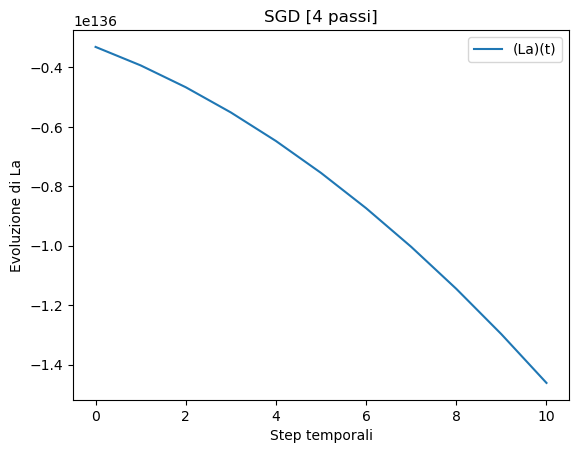

In [32]:
grafico = []
for i in range(N+1):
    grafico.append(L(a, (T / N) * i, 'canonica'))

fig = plt.figure() 
plt.title("SGD [" + str(m) + " passi]") 
plt.xlabel("Step temporali") 
plt.ylabel("Evoluzione di La") 
# plt.ylim(-1,1) # se non c'è il grafico è molto zoomato
plt.plot(grafico, label='(La)(t)')
plt.legend()
plt.show() 

OSSERVAZIONI: con m>4 fa calcoli più piccoli dell $\epsilon$ macchina